In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install pytorch-lightning
!pip install pytorchmetrics

from tqdm.notebook import tqdm
from pathlib import Path
import zipfile
import nibabel as nib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torchvision
from torchvision import datasets,models,transforms
from torchvision.utils import make_grid

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/06-Atrium-Segmentation.zip", mode = "r")
zip_file.extractall()
zip_file.close()

In [4]:
!tar -xvf /content/drive/MyDrive/PyTorch_Vol3/Task02_Heart.tar

Task02_Heart/._dataset.json
Task02_Heart/dataset.json
Task02_Heart/._imagesTr
Task02_Heart/imagesTr/
Task02_Heart/imagesTr/la_007.nii.gz
Task02_Heart/imagesTr/la_019.nii.gz
Task02_Heart/imagesTr/la_023.nii.gz
Task02_Heart/imagesTr/la_005.nii.gz
Task02_Heart/imagesTr/la_009.nii.gz
Task02_Heart/imagesTr/la_017.nii.gz
Task02_Heart/imagesTr/la_021.nii.gz
Task02_Heart/imagesTr/._la_029.nii.gz
Task02_Heart/imagesTr/la_029.nii.gz
Task02_Heart/imagesTr/la_003.nii.gz
Task02_Heart/imagesTr/la_011.nii.gz
Task02_Heart/imagesTr/la_030.nii.gz
Task02_Heart/imagesTr/la_022.nii.gz
Task02_Heart/imagesTr/la_014.nii.gz
Task02_Heart/imagesTr/la_018.nii.gz
Task02_Heart/imagesTr/la_020.nii.gz
Task02_Heart/imagesTr/la_004.nii.gz
Task02_Heart/imagesTr/la_016.nii.gz
Task02_Heart/imagesTr/la_024.nii.gz
Task02_Heart/imagesTr/la_010.nii.gz
Task02_Heart/imagesTr/la_026.nii.gz
Task02_Heart/._imagesTs
Task02_Heart/imagesTs/
Task02_Heart/imagesTs/la_015.nii.gz
Task02_Heart/imagesTs/la_025.nii.gz
Task02_Heart/imagesTs/

In [5]:
root = Path("/content/Task02_Heart/imagesTr")
label = Path("/content/Task02_Heart/labelsTr")

In [6]:
list(root.parts)

['/', 'content', 'Task02_Heart', 'imagesTr']

In [7]:
parts = list(root.parts)
parts.index("imagesTr"),parts[2]

(3, 'Task02_Heart')

In [8]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [9]:
root,change_img_to_label_path(root)

(PosixPath('/content/Task02_Heart/imagesTr'),
 PosixPath('/content/Task02_Heart/labelsTr'))

In [10]:
sample_path = list(root.glob("la*"))[0]
sample_path

PosixPath('/content/Task02_Heart/imagesTr/la_024.nii.gz')

In [11]:
sample_path_label = change_img_to_label_path(sample_path)
sample_path, sample_path_label

(PosixPath('/content/Task02_Heart/imagesTr/la_024.nii.gz'),
 PosixPath('/content/Task02_Heart/labelsTr/la_024.nii.gz'))

In [12]:
data = nib.load(sample_path)
labels = nib.load(sample_path_label)

mri = data.get_fdata()
mask = labels.get_fdata().astype(np.uint8)

In [13]:
nib.aff2axcodes(data.affine),nib.aff2axcodes(labels.affine)

(('R', 'A', 'S'), ('R', 'A', 'S'))

In [14]:
%%capture
!pip install celluloid

from celluloid import Camera
from IPython.display import HTML

from warnings import filterwarnings
filterwarnings("ignore")

In [15]:
mri.shape, mask.shape

((320, 320, 120), (320, 320, 120))

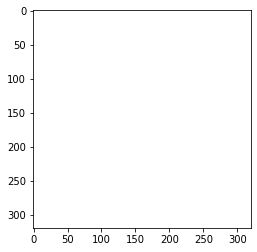

In [16]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i] , cmap = "bone")
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha = 0.5)
    camera.snap()

animation = camera.animate()

In [17]:
HTML(animation.to_html5_video())

In [18]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [19]:
root,label

(PosixPath('/content/Task02_Heart/imagesTr'),
 PosixPath('/content/Task02_Heart/labelsTr'))

In [20]:
all_files = list(root.glob("la*"))
len(all_files)

20

In [21]:
deneme = nib.load(all_files[0]).get_fdata()
deneme.shape, deneme[32:-32, 32:-32].shape

((320, 320, 120), (256, 256, 120))

In [22]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_mri_data)

    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]

    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    for i in range(standardized_mri_data.shape[-1]):

        slice = standardized_mri_data[:, :, i]
        mask = label_data[:, :, i]

        slice_path = current_path/"data"
        mask_path = current_path/"masks"

        slice_path.mkdir(parents = True, exist_ok = True)
        mask_path.mkdir(parents = True, exist_ok = True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
path = Path("Preprocessed/train/0")
path

PosixPath('Preprocessed/train/0')

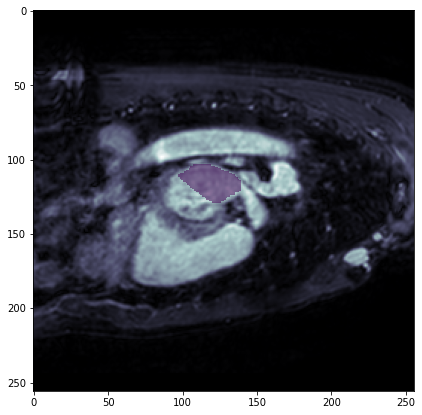

In [24]:
file = "50.npy"
slice = np.load(path/"data"/file)
mask =  np.load(path/"masks"/file)

plt.figure(figsize= (7,7))
plt.imshow(slice, cmap = "bone")
mask_ = np.ma.masked_where(mask == 0, mask)
plt.imshow(mask_, alpha =.5)
plt.show()

---

In [30]:
%%capture 
!pip install imgaug==0.4.0
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from IPython.core.pylabtools import select_figure_formats
import imgaug.augmenters as iaa

imgaug.__version__

In [31]:
imgaug.__version__

'0.4.0'

In [32]:
from imgaug.augmenters import segmentation
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):
            slice_path = subject/"data"
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files
    
    @staticmethod
    def change_img_to_label_path(path):

        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):

        random_seed = torch.randint(0,100000, (1,)).item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image = slice, segmentation_maps = mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self,idx):

        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)

        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice, mask = self.augment(slice,mask)
            
        return np.expand_dims(slice, 0 ), np.expand_dims(mask, 0)

In [33]:
seq = iaa.Sequential([
                      iaa.Affine(
                          scale = (0.85, 1.15),
                          rotate = (-45,45)
                      ),
                      iaa.ElasticTransformation()
])

In [34]:
path = Path("/content/Preprocessed/train")
dataset = CardiacDataset(path, seq)

In [35]:
len(dataset)

1951

In [38]:
slice , mask = dataset[0]
slice.shape, mask.shape

((1, 256, 256), (1, 256, 256))

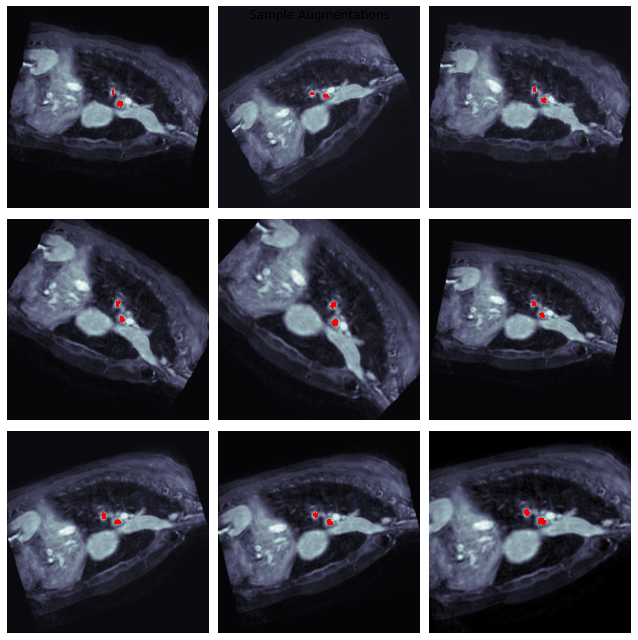

In [40]:
fig , axis = plt.subplots(3,3,figsize = (9,9))

axis = axis.ravel()

for i in range(len(axis)):

    slice, mask = dataset[1]
    mask_ = np.ma.masked_where(mask == 0, mask)
    axis[i].imshow(slice[0], cmap = "bone")
    axis[i].imshow(mask_[0], cmap = "autumn")
    axis[i].axis("off")

plt.suptitle("Sample Augmentations")
plt.tight_layout()
plt.show()

----

In [41]:
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels,out_channels, kernel_size = 3, padding =1),
                                        torch.nn.ReLU())
        
    def forward(self,X):
        return self.step(X)

In [69]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1,64)
        self.layer2 = DoubleConv(64,128)
        self.layer3 = DoubleConv(128,256)
        self.layer4 = DoubleConv(256,512)

        self.layer5 = DoubleConv(512 + 256 ,256)
        self.layer6 = DoubleConv(256+128,128)
        self.layer7 = DoubleConv(128+64,64)
        self.layer8 = torch.nn.Conv2d(64,1,1)

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self,x):

        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
         
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
       
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
       
        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x4)
        x5 = torch.cat([x5,x3],dim = 1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x5)
        x6 = torch.cat([x6,x2],dim = 1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x6)
        x7 = torch.cat([x7,x1],dim = 1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)

        return ret

In [70]:
layer1 = DoubleConv(1,64)
layer2 = DoubleConv(64,128)
layer3 = DoubleConv(128,256)
layer4 = DoubleConv(256,512)

layer5 = DoubleConv(512 + 256 ,256)
layer6 = DoubleConv(256+128,128)
layer7 = DoubleConv(128+64,64)
layer8 = torch.nn.Conv2d(64,1,1)
maxpool = torch.nn.MaxPool2d(2)

In [71]:
input = torch.randn(1,1,256,256)
input.shape

torch.Size([1, 1, 256, 256])

In [72]:
x1 = layer1(input)
x1m = maxpool(x1)
 
x2 = layer2(x1m)
x2m = maxpool(x2)

x3 = layer3(x2m)
x3m = maxpool(x3)

x4 = layer4(x3m)

liste = [input.shape,x1.shape,x1m.shape,x2.shape,x2m.shape,x3.shape,x3m.shape,x4.shape]
for i in liste:
    print(i)

torch.Size([1, 1, 256, 256])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 32, 32])


In [73]:
x5 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x4)
print(x5.shape)
print(x3.shape)
x5 = torch.cat([x5,x3], dim = 1)
print(x5.shape)
x5 = layer5(x5)
print(x5.shape)

torch.Size([1, 512, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([1, 768, 64, 64])
torch.Size([1, 256, 64, 64])


In [74]:
x6 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x5)
x6 = torch.cat([x6,x2], dim = 1)
x6 = layer6(x6)

x7 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x6)
x7 = torch.cat([x7,x1], dim = 1)
x7 = layer7(x7)

ret = layer8(x7)

liste = [x5.shape,x6.shape,x7.shape,ret.shape]
for i in liste:
    print(i)

torch.Size([1, 256, 64, 64])
torch.Size([1, 128, 128, 128])
torch.Size([1, 64, 256, 256])
torch.Size([1, 1, 256, 256])


In [75]:
model = UNet()
for name,param in model.named_parameters():
    print(name, param.shape)
    print("".center(100,"*"))

layer1.step.0.weight torch.Size([64, 1, 3, 3])
****************************************************************************************************
layer1.step.0.bias torch.Size([64])
****************************************************************************************************
layer1.step.2.weight torch.Size([64, 64, 3, 3])
****************************************************************************************************
layer1.step.2.bias torch.Size([64])
****************************************************************************************************
layer2.step.0.weight torch.Size([128, 64, 3, 3])
****************************************************************************************************
layer2.step.0.bias torch.Size([128])
****************************************************************************************************
layer2.step.2.weight torch.Size([128, 128, 3, 3])
*******************************************************************************************

In [76]:
random_input = torch.randn(1,1,256,256)
output = model(random_input)
assert output.shape == torch.Size([1,1,256,256])

In [82]:
random_input.mean(),output.mean()

(tensor(-0.0059), tensor(-0.0779, grad_fn=<MeanBackward0>))

----

In [77]:
seq = iaa.Sequential([
                      iaa.Affine(scale = (0.85, 1.15),
                                 rotate = (-45,45)),
                      iaa.ElasticTransformation()
])

In [78]:
train_path = Path("/content/Preprocessed/train")
val_path = Path("/content/Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [79]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = False)

In [81]:
class DiceLoss(torch.nn.Module):

    def __init__(self):

        super().__init__()

    def forward(self,pred, mask):

        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred*mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter) / denum

        return 1 - dice

In [88]:
class AtriumSegmentation(pl.LightningModule):

    def __init__(self):

        super().__init__()
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):

        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):

        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def log_images(self, mri ,pred, mask, name):

        pred = pred > 0.5

        fig, axis = plt.subplots(1,2,figsize = (12,12))
        axis[0].imshow(mri[0][0], cmap = "bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_,alpha = .6)

        axis[1].imshow(mri[0][0], cmap = "bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[1].imshow(mask_,alpha = .6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [89]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [90]:
checkpoint_callback = ModelCheckpoint(monitor = "Val Dice", 
                                      save_top_k = 10,
                                      mode = "min")

In [91]:
gpus = 0
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "/content/logs"),
                     log_every_n_steps = 1, callbacks = checkpoint_callback, max_epochs = 75 )

In [92]:
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

----

In [92]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [93]:
model = AtriumSegmentation.load_from_checkpoint("/content/06-Atrium-Segmentation/weights/70.ckpt")

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device);

In [96]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)

    preds.append(pred.cpu().numpy())
    labels.append(label)

  0%|          | 0/320 [00:00<?, ?it/s]

In [97]:
pred.shape,label.shape,slice.shape

(torch.Size([1, 1, 256, 256]), (1, 256, 256), torch.Size([1, 1, 256, 256]))

In [101]:
preds = np.array(preds)
labels = np.array(labels)

In [102]:
1- model.loss_fn(torch.from_numpy(preds),torch.from_numpy(labels))

tensor(0.9486)

In [106]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.9485598206520081


In [108]:
subject = "/content/Task02_Heart/imagesTs/la_002.nii.gz"
subject_mri = nib.load(subject).get_fdata()
subject_mri = subject_mri[32: -32, 32: -32]

standardized_scan = standardize(normalize(subject_mri))

In [109]:
standardized_scan.shape

(256, 256, 140)

In [111]:
preds = []

for i in range(standardized_scan.shape[-1]):

    slice = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5

    preds.append(pred.cpu())

In [116]:
pred.shape,len(preds)

(torch.Size([256, 256]), 140)

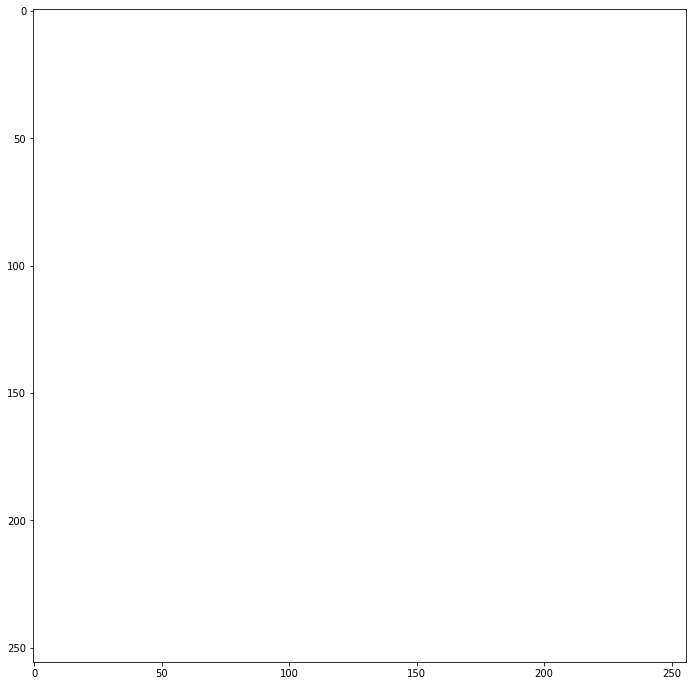

In [117]:
fig = plt.figure(figsize = (12,12))
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):

    plt.imshow(standardized_scan[:, :, i], cmap = "bone")
    mask = np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask , alpha = 0.5)
    camera.snap()

animation = camera.animate()

In [118]:
HTML(animation.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.